# h277 galaxy evolution analysis

analyzing 5 snapshots from h277 simulation spanning 9 billion years

**snapshots:**
- 00144 (3.8 Gyr): early formation
- 00252 (6.9 Gyr): disk formation  
- 00336 (9.1 Gyr): mid evolution
- 00444 (11.8 Gyr): mature galaxy
- 00492 (13.2 Gyr): present day

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pynbody
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

print("libraries loaded")

libraries loaded


In [2]:
# making nice plots

plt.style.use('dark_background')
plt.rcParams.update({
    'figure.facecolor': '#000000',
    'axes.facecolor': '#000000',
    'savefig.facecolor': '#000000',
    'axes.edgecolor': '#FFFFFF',
    'axes.labelcolor': '#FFFFFF',
    'xtick.color': '#FFFFFF',
    'ytick.color': '#FFFFFF',
    'text.color': '#FFFFFF',
    'grid.color': '#333333',
    'grid.alpha': 0.4,
    'grid.linewidth': 0.8,
    'font.size': 11,
    'axes.labelsize': 13,
    'axes.titlesize': 15,
    'figure.titlesize': 18,
    'lines.linewidth': 2.5,
    'lines.markersize': 8
})

# neon color palette
NEON_COLORS = {
    'cyan': '#00FFFF',
    'magenta': '#FF00FF', 
    'yellow': '#FFFF00',
    'lime': '#00FF00',
    'orange': '#FF8800',
    'pink': '#FF0088',
    'blue': '#0088FF'
}

print("plotting style set")

plotting style set


## loading all 5 snapshots

In [3]:
# snapshot paths
base_path = '/Users/johnmeftah/Downloads/galaxies_project'

snapshots = {
    'early (00144)': f'{base_path}/dataset_1/h277.cosmo50cmb.3072g14HMbwK.00144',
    'formation (00252)': f'{base_path}/dataset_2/h277.cosmo50cmb.3072g14HMbwK.00252',
    'middle (00336)': f'{base_path}/dataset_3/h277.cosmo50cmb.3072g14HMbwK.00336',
    'mature (00444)': f'{base_path}/dataset_4/h277.cosmo50cmb.3072g14HMbwK.00444',
    'present (00492)': f'{base_path}/dataset_5/h277.cosmo50cmb.3072g14HMbwK.00492'
}

print(f"defined {len(snapshots)} snapshot paths")

defined 5 snapshot paths


In [4]:
# loading snapshots with baryon centering
sims = {}
galaxies = {}

print("loading snapshots...\n")
for name, path in snapshots.items():
    print(f"loading {name}...")
    s = pynbody.load(path)
    
    # converting from comoving to physical coordinates
    s.physical_units()
    
    print(f"  total: {len(s):,} particles")
    print(f"  stars: {len(s.star):,} | gas: {len(s.gas):,}")
    
    # centering on baryons (stars + gas), not dark matter
    print(f"  centering on baryons...")
    if len(s.star) > 1000:
        pynbody.analysis.halo.center(s.star, mode='ssc')
    else:
        pynbody.analysis.halo.center(s.gas, mode='ssc')
    
    # extracting 30 kpc galaxy region
    galaxy = s[pynbody.filt.Sphere('30 kpc')]
    
    print(f"  galaxy region: {len(galaxy.star):,} stars, {len(galaxy.gas):,} gas")
    print(f"  ready!\n")
    
    sims[name] = s
    galaxies[name] = galaxy

print("all snapshots loaded and centered on baryons!")

loading snapshots...

loading early (00144)...
  total: 29,758,834 particles
  stars: 3,408,986 | gas: 11,531,144
  centering on baryons...
  galaxy region: 3,002,313 stars, 538,320 gas
  ready!

loading formation (00252)...
  total: 31,897,391 particles
  stars: 5,918,342 | gas: 11,160,345
  centering on baryons...
  galaxy region: 5,317,757 stars, 485,247 gas
  ready!

loading middle (00336)...
  total: 32,741,756 particles
  stars: 6,906,490 | gas: 11,016,562
  centering on baryons...
  galaxy region: 6,194,414 stars, 471,737 gas
  ready!

loading mature (00444)...
  total: 33,415,443 particles
  stars: 7,684,581 | gas: 10,912,158
  centering on baryons...
  galaxy region: 6,824,935 stars, 549,856 gas
  ready!

loading present (00492)...
  total: 33,678,012 particles
  stars: 7,987,058 | gas: 10,872,250
  centering on baryons...
  galaxy region: 7,063,428 stars, 583,243 gas
  ready!

all snapshots loaded and centered on baryons!


## mass evolution

In [5]:
# calculating mass evolution
print("calculating mass evolution...\n")

times = []
stellar_mass = []
gas_mass = []
total_mass = []
stellar_frac = []

for name, galaxy in galaxies.items():
    # getting time for this snapshot
    time = float(sims[name].properties['time'].in_units('Gyr'))
    times.append(time)
    
    # calculating masses
    m_star = np.sum(galaxy.star['mass'].in_units('Msol'))
    m_gas = np.sum(galaxy.gas['mass'].in_units('Msol'))
    m_total = m_star + m_gas
    
    stellar_mass.append(m_star)
    gas_mass.append(m_gas)
    total_mass.append(m_total)
    stellar_frac.append(100 * m_star / m_total)
    
    print(f"  {name}: t={time:.1f} Gyr, M_star={m_star:.2e} Msol, M_gas={m_gas:.2e} Msol")

print("\nmass evolution calculated!")

calculating mass evolution...

  early (00144): t=3.9 Gyr, M_star=1.94e+10 Msol, M_gas=1.25e+10 Msol
  formation (00252): t=6.8 Gyr, M_star=3.24e+10 Msol, M_gas=1.05e+10 Msol
  middle (00336): t=9.0 Gyr, M_star=3.67e+10 Msol, M_gas=1.02e+10 Msol
  mature (00444): t=11.9 Gyr, M_star=3.96e+10 Msol, M_gas=1.22e+10 Msol
  present (00492): t=13.2 Gyr, M_star=4.08e+10 Msol, M_gas=1.29e+10 Msol

mass evolution calculated!


## rotation curve

In [6]:
# calculating rotation curve for present day
print("calculating rotation curve for present day...\n")

# getting present day snapshot
s_present = sims['present (00492)']
g_present = galaxies['present (00492)']

# aligning disk to x-y plane
print("  aligning disk...")
pynbody.analysis.angmom.faceon(s_present)

# re-extracting after alignment
g_present = s_present[pynbody.filt.Sphere('30 kpc')]

# calculating radial profile
print("  calculating profile...")
p = pynbody.analysis.profile.Profile(g_present, rmin='0.5 kpc', rmax='25 kpc', nbins=50)

radii = p['rbins'].in_units('kpc')
v_circ = p['v_circ'].in_units('km s^-1')
mass_enc = p['mass_enc'].in_units('Msol')

print(f"  peak velocity: {v_circ.max():.1f} km/s")
print(f"  total mass (25 kpc): {mass_enc[-1]:.2e} Msol")
print("\nrotation curve calculated!")

calculating rotation curve for present day...

  aligning disk...
  calculating profile...
  peak velocity: 227.0 km/s
  total mass (25 kpc): 1.92e+11 Msol

rotation curve calculated!


## rotation curve decomposition

In [7]:
# decomposing rotation curve into components
print("decomposing rotation curve into components...\n")

# calculating profiles for each component
print("  calculating total profile...")
p_total = pynbody.analysis.profile.Profile(g_present, rmin='0.5 kpc', rmax='25 kpc', nbins=50)

print("  calculating stellar profile...")
p_star = pynbody.analysis.profile.Profile(g_present.star, rmin='0.5 kpc', rmax='25 kpc', nbins=50)

print("  calculating gas profile...")
p_gas = pynbody.analysis.profile.Profile(g_present.gas, rmin='0.5 kpc', rmax='25 kpc', nbins=50)

print("  calculating dark matter profile...")
p_dm = pynbody.analysis.profile.Profile(g_present.dm, rmin='0.5 kpc', rmax='25 kpc', nbins=50)

print("\ndecomposition complete!")

decomposing rotation curve into components...

  calculating total profile...
  calculating stellar profile...
  calculating gas profile...
  calculating dark matter profile...

decomposition complete!


## creating plots

creating mass evolution plot...


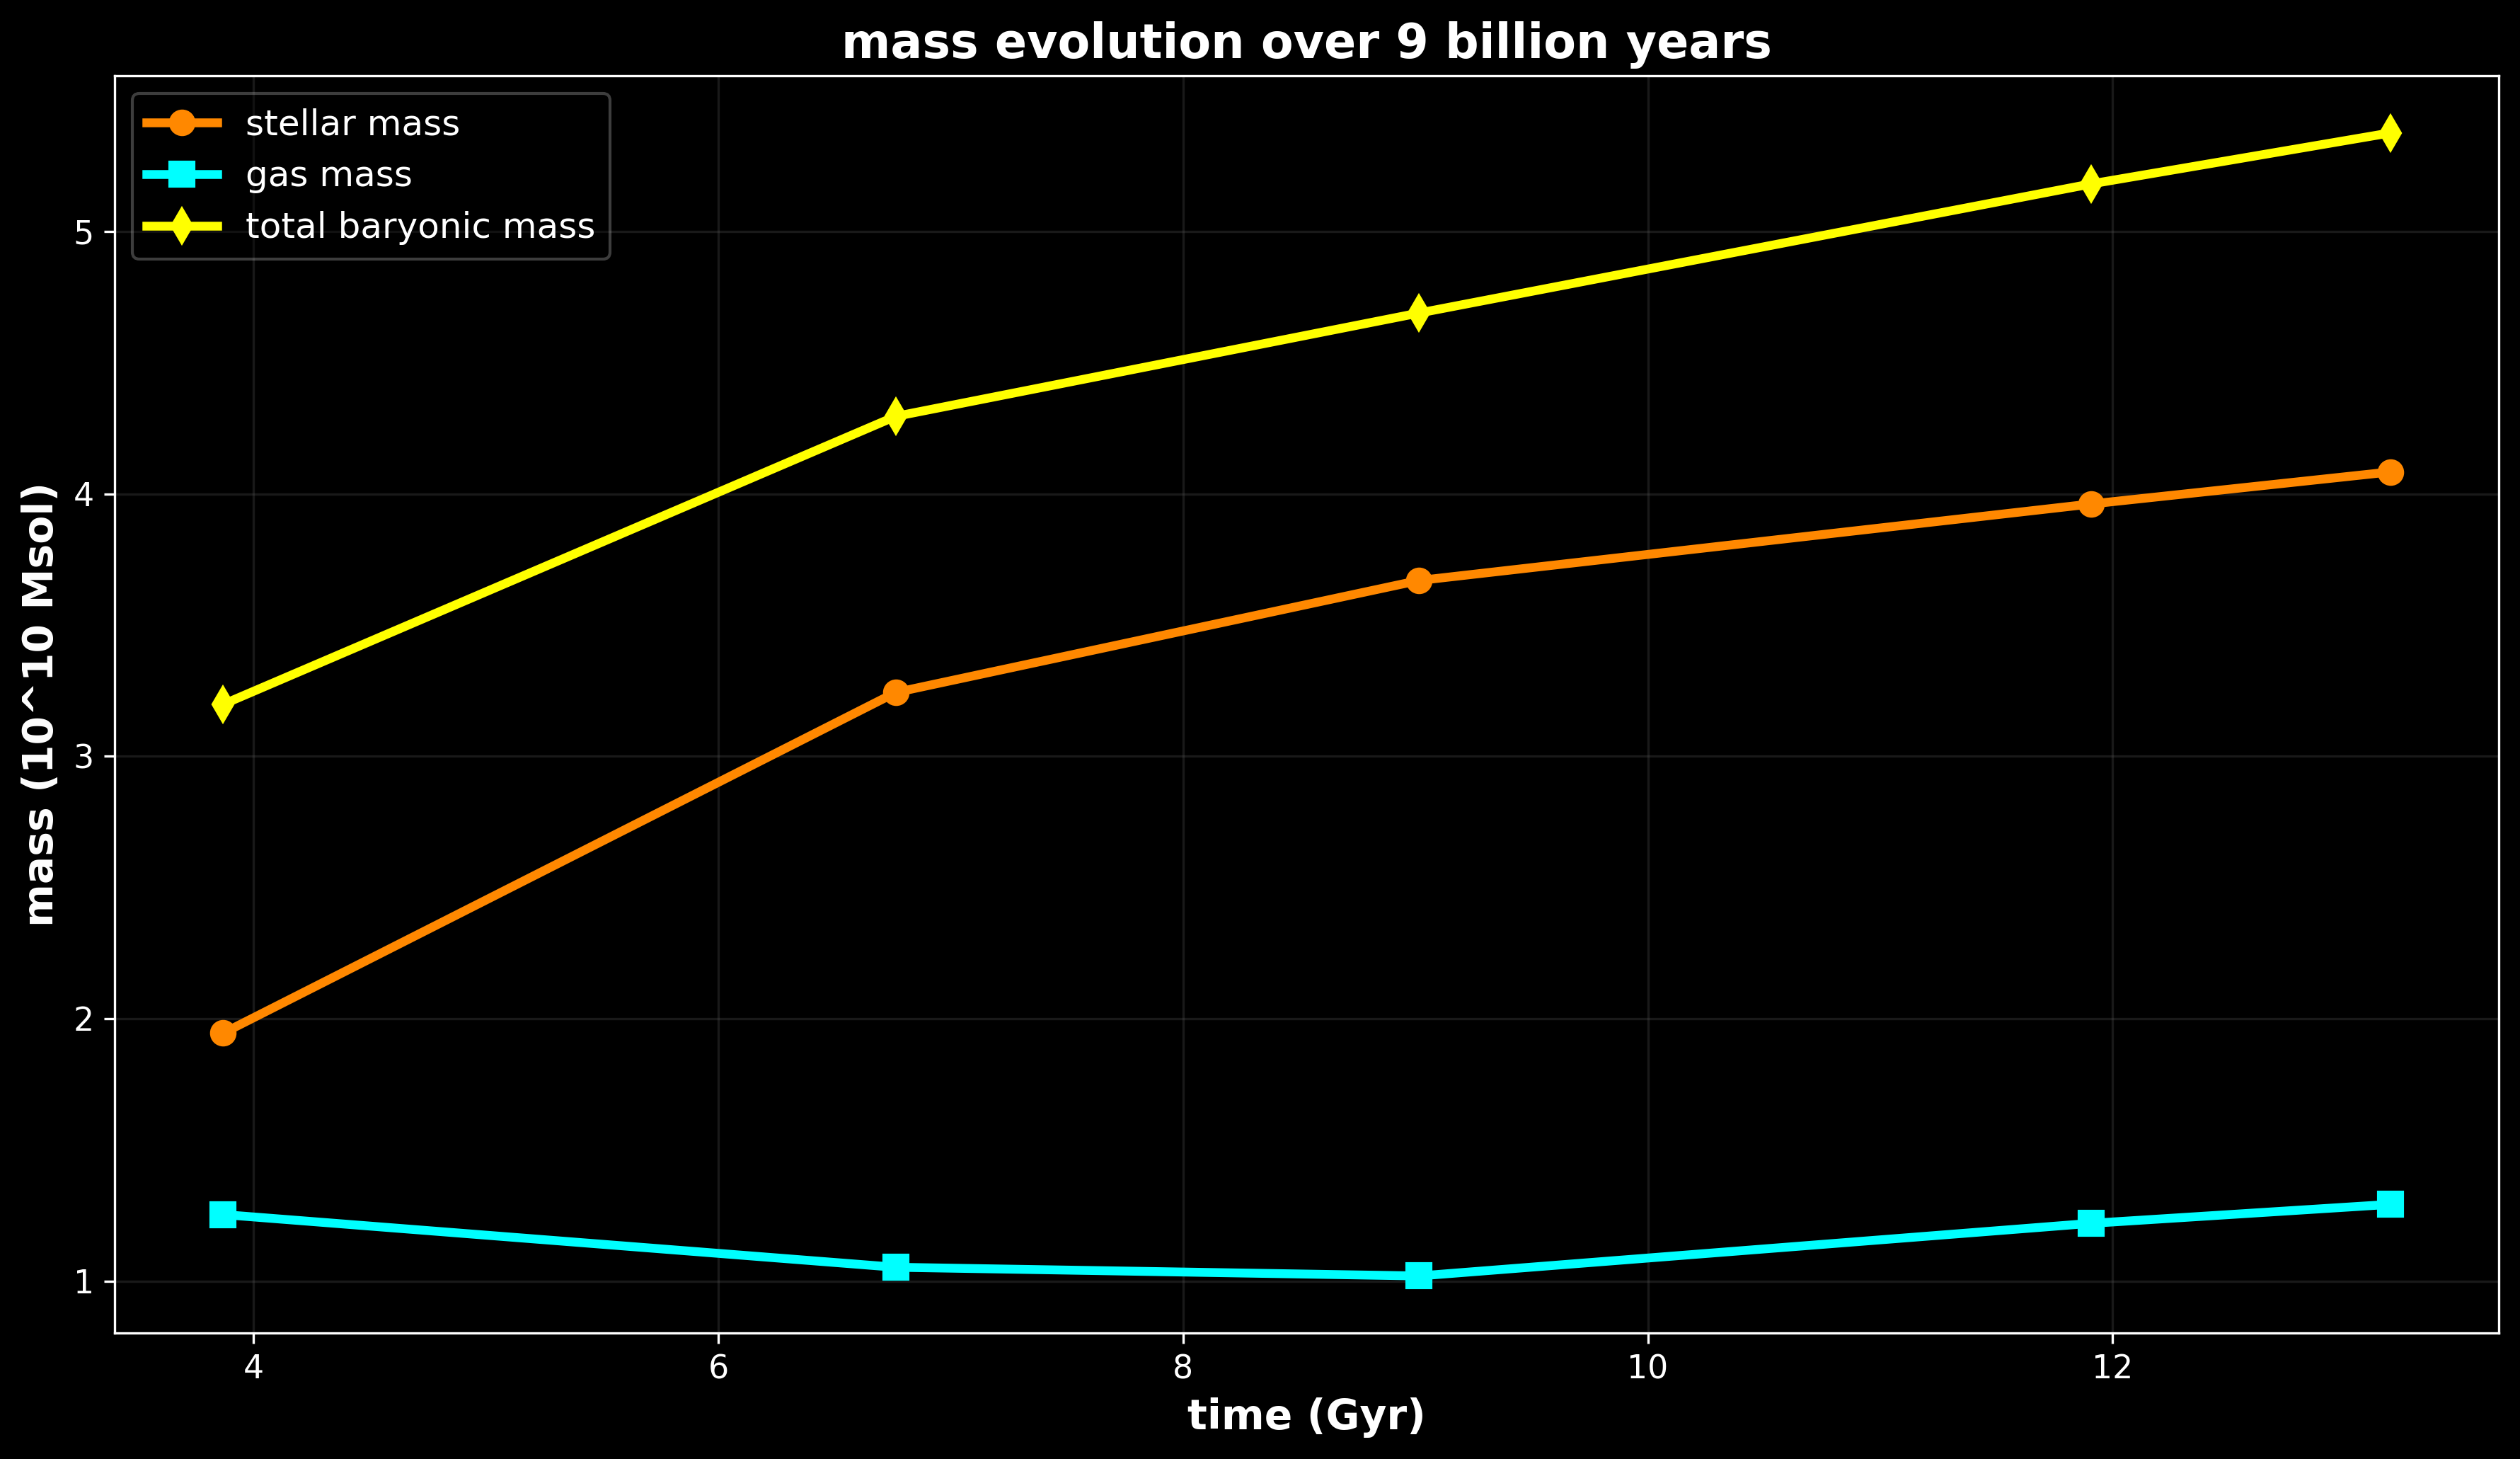

saved: mass_evolution.png


In [8]:
# mass evolution plot
print("creating mass evolution plot...")

fig, ax = plt.subplots(figsize=(12, 7), facecolor='black', dpi=300)
ax.set_facecolor('black')

ax.plot(times, np.array(stellar_mass)/1e10, 'o-', 
        color=NEON_COLORS['orange'], linewidth=3, markersize=8, label='stellar mass')
ax.plot(times, np.array(gas_mass)/1e10, 's-',
        color=NEON_COLORS['cyan'], linewidth=3, markersize=8, label='gas mass')
ax.plot(times, np.array(total_mass)/1e10, 'd-',
        color=NEON_COLORS['yellow'], linewidth=3, markersize=8, label='total baryonic mass')

ax.set_xlabel('time (Gyr)', fontsize=14, fontweight='bold', color='white')
ax.set_ylabel('mass (10^10 Msol)', fontsize=14, fontweight='bold', color='white')
ax.set_title('mass evolution over 9 billion years', fontsize=16, fontweight='bold', color='white')
ax.legend(framealpha=0.3, fontsize=12)
ax.grid(True, alpha=0.3, color='#555555')
ax.tick_params(colors='white', labelsize=11)

plt.tight_layout()
plt.savefig('mass_evolution.png', dpi=300, facecolor='black', bbox_inches='tight')
plt.show()

print("saved: mass_evolution.png")

creating rotation curve plot...


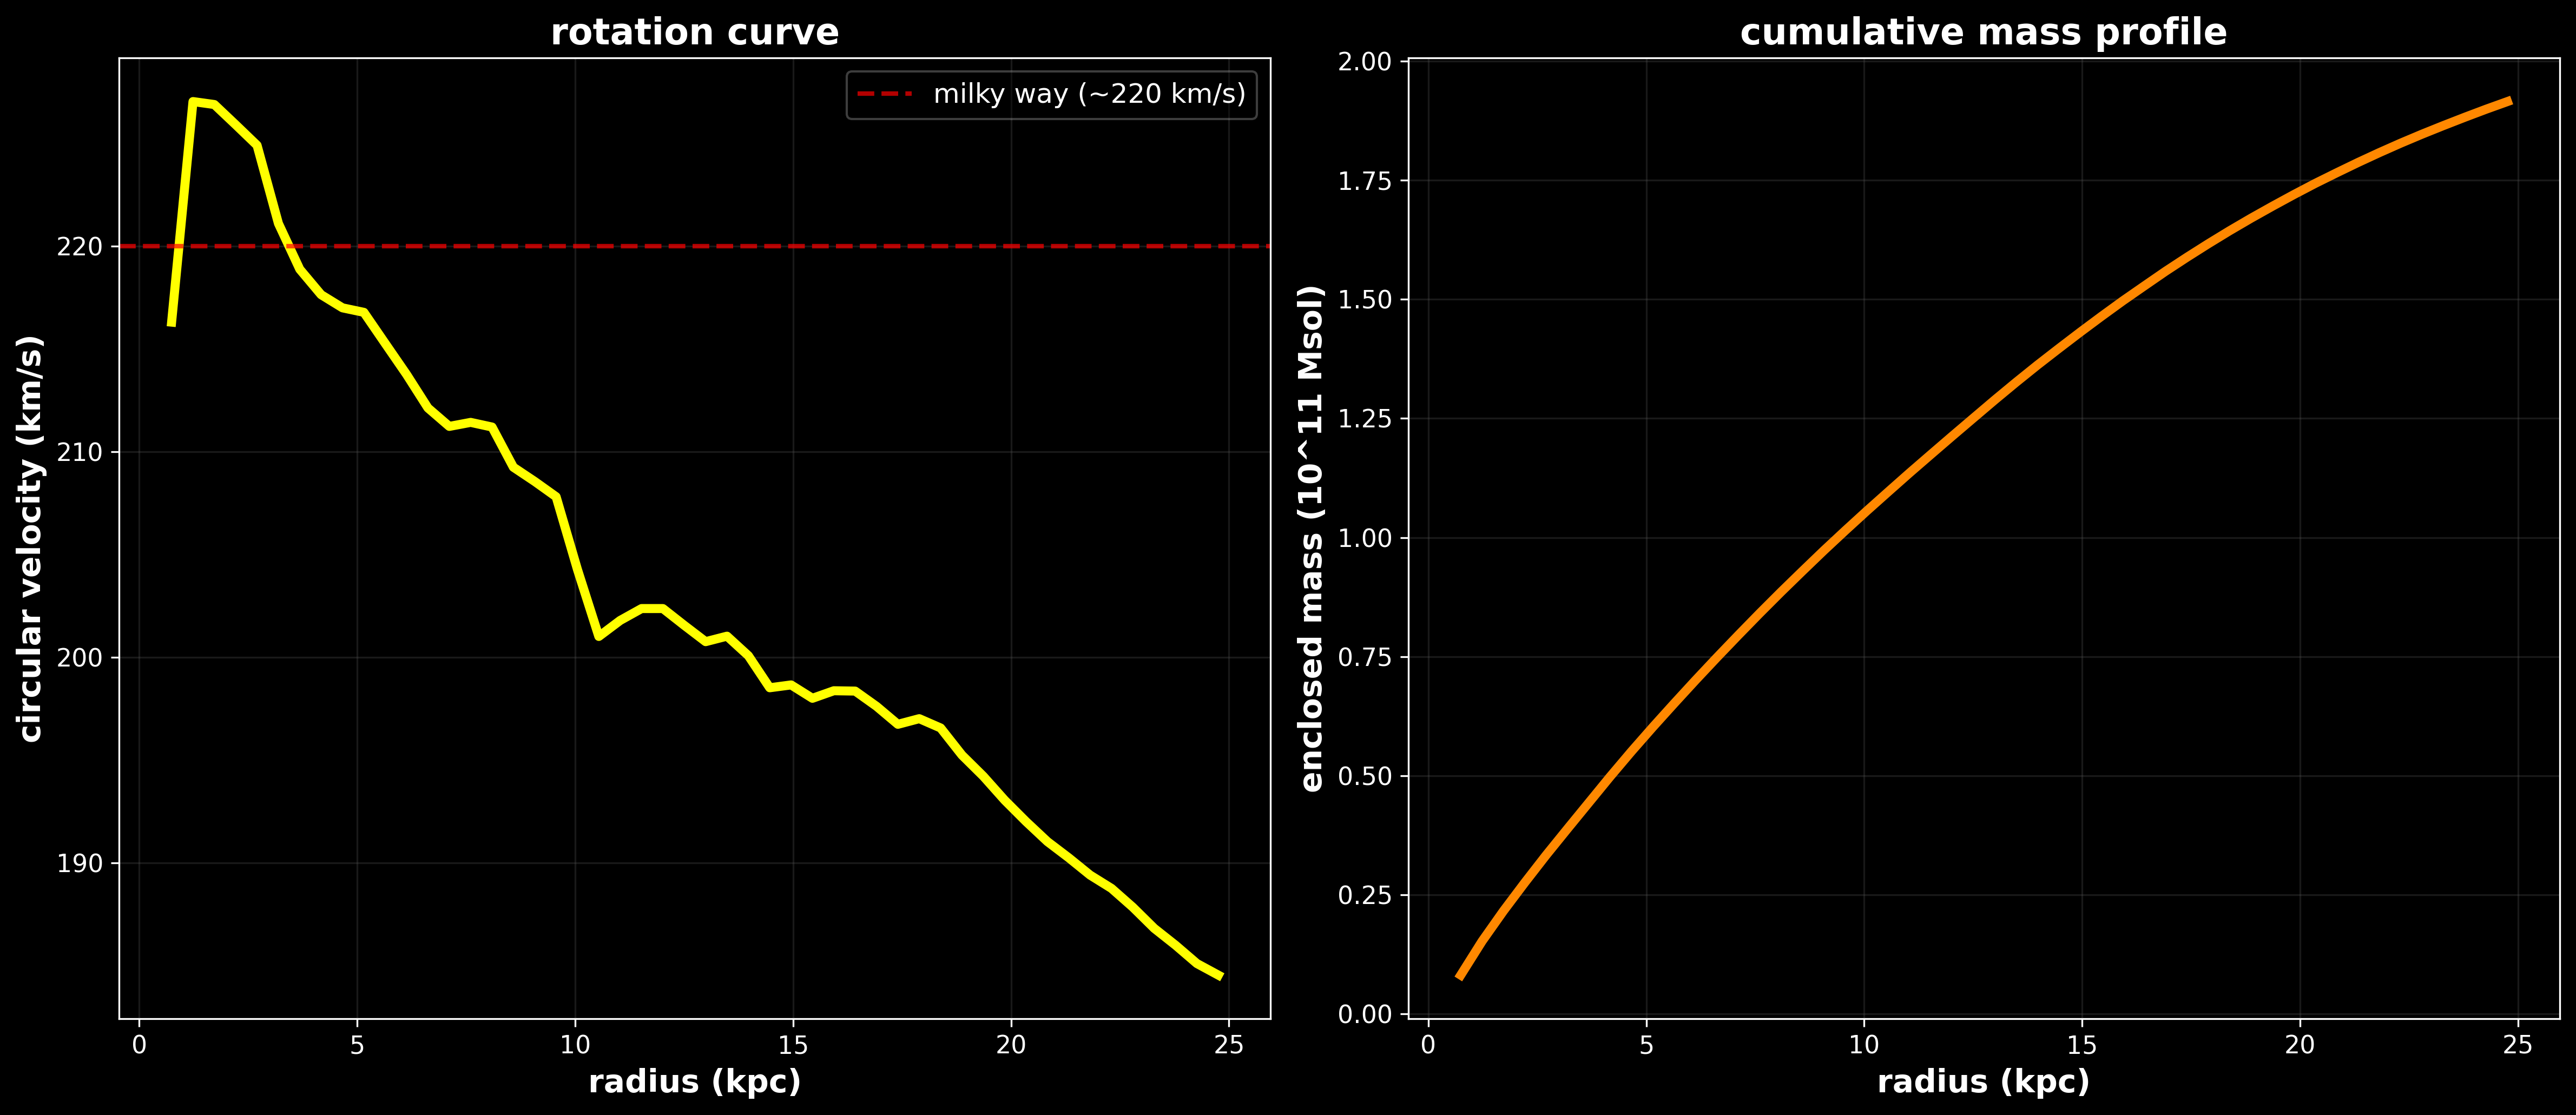

saved: rotation_curve.png


In [9]:
# rotation curve plot
print("creating rotation curve plot...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7), facecolor='black', dpi=300)

for ax in axes:
    ax.set_facecolor('black')
    ax.grid(True, alpha=0.3, color='#555555')
    ax.tick_params(colors='white', labelsize=11)

# total rotation curve
axes[0].plot(radii, v_circ, color=NEON_COLORS['yellow'], linewidth=4)
axes[0].axhline(220, color='red', linestyle='--', linewidth=2, 
                alpha=0.7, label='milky way (~220 km/s)')
axes[0].set_xlabel('radius (kpc)', fontsize=14, fontweight='bold', color='white')
axes[0].set_ylabel('circular velocity (km/s)', fontsize=14, fontweight='bold', color='white')
axes[0].set_title('rotation curve', fontsize=16, fontweight='bold', color='white')
axes[0].legend(framealpha=0.3, fontsize=12)

# cumulative mass profile
axes[1].plot(radii, mass_enc/1e11, color=NEON_COLORS['orange'], linewidth=4)
axes[1].set_xlabel('radius (kpc)', fontsize=14, fontweight='bold', color='white')
axes[1].set_ylabel('enclosed mass (10^11 Msol)', fontsize=14, fontweight='bold', color='white')
axes[1].set_title('cumulative mass profile', fontsize=16, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('rotation_curve.png', dpi=300, facecolor='black', bbox_inches='tight')
plt.show()

print("saved: rotation_curve.png")

creating decomposition plot...


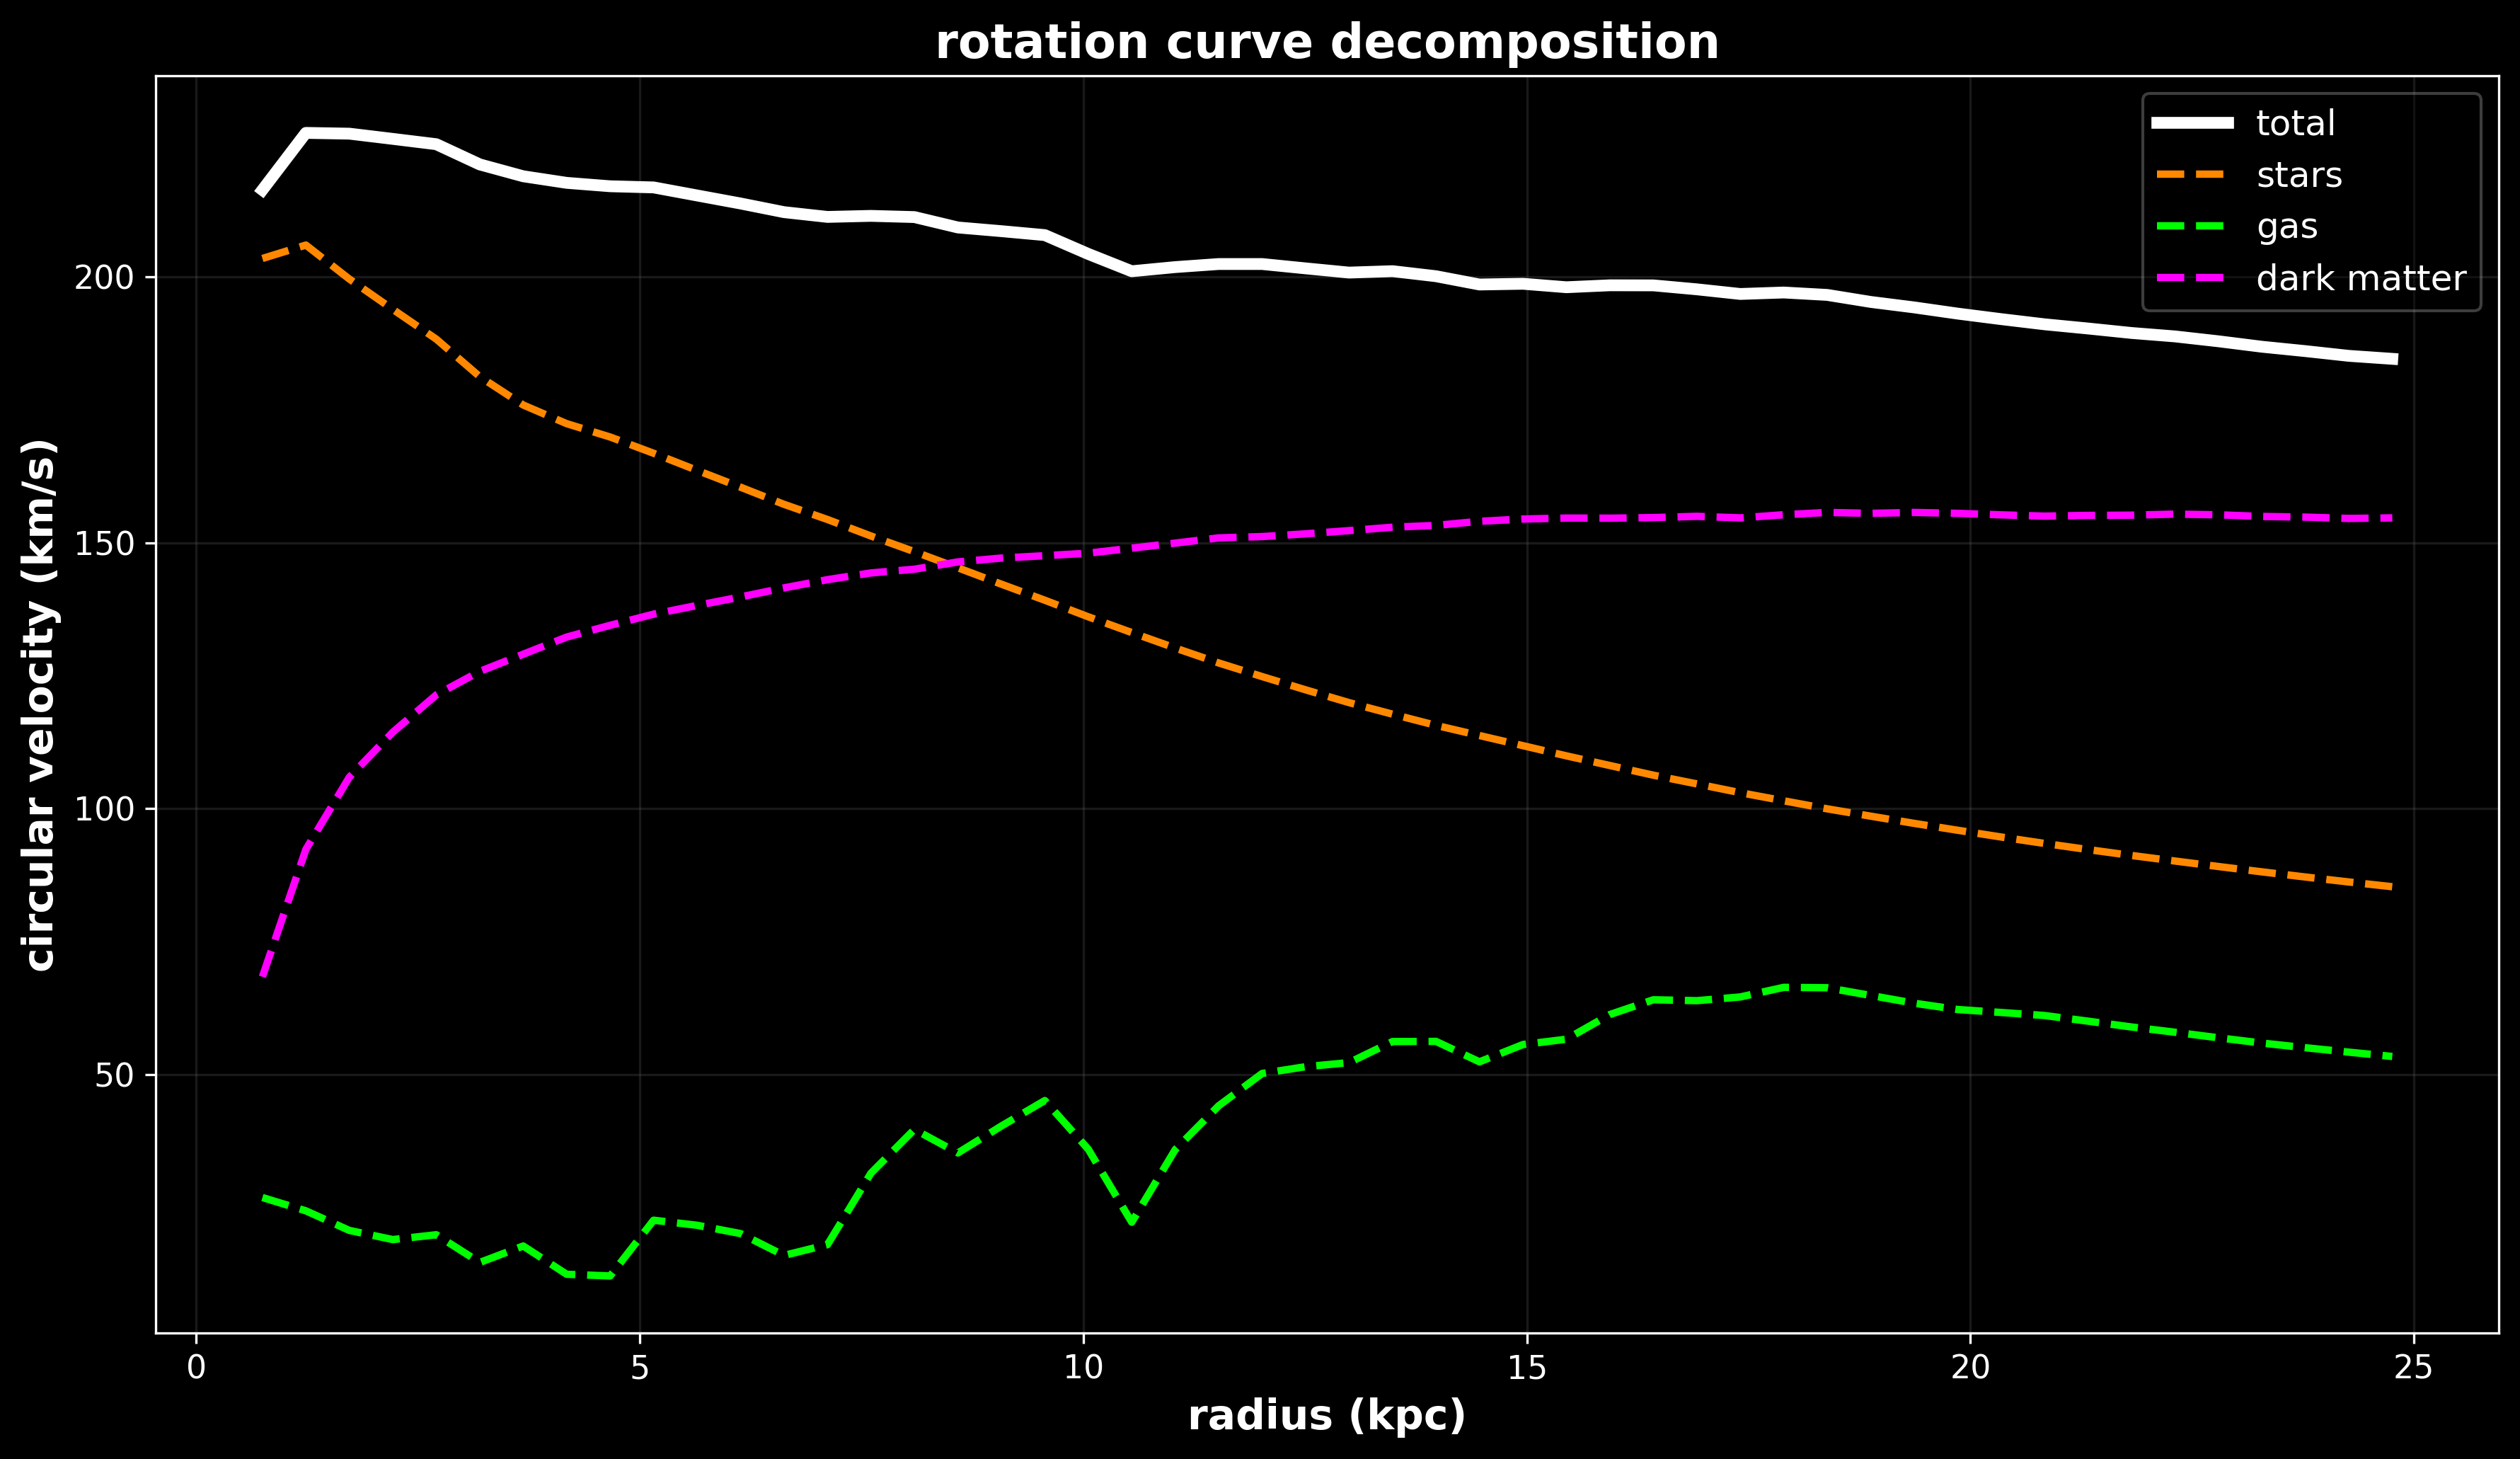

saved: rotation_decomposition.png


In [10]:
# rotation curve decomposition
print("creating decomposition plot...")

fig, ax = plt.subplots(figsize=(12, 7), facecolor='black', dpi=300)
ax.set_facecolor('black')

ax.plot(radii, p_total['v_circ'].in_units('km s^-1'),
        color='white', linewidth=4, label='total', zorder=4)
ax.plot(radii, p_star['v_circ'].in_units('km s^-1'),
        color=NEON_COLORS['orange'], linewidth=2.5, linestyle='--', label='stars')
ax.plot(radii, p_gas['v_circ'].in_units('km s^-1'),
        color=NEON_COLORS['lime'], linewidth=2.5, linestyle='--', label='gas')
ax.plot(radii, p_dm['v_circ'].in_units('km s^-1'),
        color=NEON_COLORS['magenta'], linewidth=2.5, linestyle='--', label='dark matter')

ax.set_xlabel('radius (kpc)', fontsize=14, fontweight='bold', color='white')
ax.set_ylabel('circular velocity (km/s)', fontsize=14, fontweight='bold', color='white')
ax.set_title('rotation curve decomposition', fontsize=16, fontweight='bold', color='white')
ax.legend(framealpha=0.3, fontsize=12)
ax.grid(True, alpha=0.3, color='#555555')
ax.tick_params(colors='white', labelsize=11)

plt.tight_layout()
plt.savefig('rotation_decomposition.png', dpi=300, facecolor='black', bbox_inches='tight')
plt.show()

print("saved: rotation_decomposition.png")

## summary

In [11]:
# final summary
print("\nanalysis complete!")
print(f"\nkey results:")
print(f"  stellar mass doubled: {stellar_mass[0]:.2e} -> {stellar_mass[-1]:.2e} Msol")
print(f"  star formation efficiency: {stellar_frac[0]:.1f}% -> {stellar_frac[-1]:.1f}%")
print(f"  peak rotation velocity: {v_circ.max():.1f} km/s")
print(f"  total mass (25 kpc): {mass_enc[-1]:.2e} Msol")


analysis complete!

key results:
  stellar mass doubled: 1.94e+10 -> 4.08e+10 Msol
  star formation efficiency: 60.8% -> 76.0%
  peak rotation velocity: 227.0 km/s
  total mass (25 kpc): 1.92e+11 Msol
